# 工具集

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd



class EarlyStopping: # 早停法
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

    
class SurvivalAnalysisModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, output_size):
        super(SurvivalAnalysisModel, self).__init__()
#         self.nb1 = torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do1 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.do2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.do3 = nn.Dropout(0.2)
        self.dense3 = nn.Linear(hidden_size, hidden_size)
        self.do4 = nn.Dropout(0.2)
        self.dense4 = nn.Linear(hidden_size, hidden_size)
        self.do5 = nn.Dropout(0.2)
        self.dense5 = nn.Linear(hidden_size, hidden_size)
        self.do6 = nn.Dropout(0.5)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads), num_layers
        )
        self.output = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size)        
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        x = self.do1(x)
        x = self.dense1(x)
        x = self.do2(x)
        x = self.dense2(x)
#         x = self.do3(x)
#         x = self.dense3(x)
#         x = self.do4(x)
#         x = self.dense4(x)
#         x = self.do5(x)
#         x = self.dense5(x)
#         x = self.do6(x)
        x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)
        x = self.output(x)
#         x = self.bn(x)
        x = self.sigmoid(x)
        return x
    
    
class SurvivalAnalysisDataset(Dataset):
    def __init__(self, n_patients, n_features):
        self.features = torch.randn(n_patients, n_features)
        self.times = torch.randint(1, 240, (n_patients,)).float()
        self.events = torch.randint(0, 2, (n_patients,)).float()
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.times[idx], self.events[idx]
    

class SurvivalDataset(Dataset):
    def __init__(self, features, times, events):
        self.features = features
        self.times = times
        self.events = events
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.times[index], self.events[index]

class BalancedSurvivalDataset(SurvivalDataset):
    def init_(self, *args, **kwargs):
        super(BalancedSurvivalDataset, self).__init__(*args, **kwargs)
        self.positive_indices = np.where(self.events == 1)[0]
        self.negative_indices = np.where(self.events == 0)[0]
        self.n_positives = len(self.positive_indices)
        self.n_negatives = len(self.negative_indices)
    
def auc_trapezoidal(y):
    area = 0
    area = np.sum(y[:, 1:-1], axis=1) + (y[:, 0] + y[:, 1])/2
    return area

def c_index(pred_times, true_times, events):
    n = len(pred_times)
    concordant = 0
    permissible = 0
    tied_risk = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            if events[i] == 1 and events[j] == 1:
                if true_times[i] < true_times[j]:
                    if pred_times[i] < pred_times[j]:
                        concordant += 1
                    elif pred_times[i] == pred_times[j]:
                        tied_risk += 1
                    permissible += 1
                elif true_times[i] > true_times[j]:
                    if pred_times[i] > pred_times[j]:
                        concordant += 1
                    elif pred_times[i] == pred_times[j]:
                        tied_risk += 1
                    permissible += 1
            elif (events[i] == 1 and events[j] == 0) and true_times[i] < true_times[j]:
                permissible += 1
                if  pred_times[i] < pred_times[j]:
                    concordant += 1
                elif pred_times[i] == pred_times[j]:
                    tied_risk += 1
            elif (events[i] == 0 and events[j] == 1) and true_times[i] > true_times[j]:
                permissible += 1
                if  pred_times[i] > pred_times[j]:
                    concordant += 1
                elif pred_times[i] == pred_times[j]:
                    tied_risk += 1
    return (concordant + 0.5 * tied_risk) / permissible if permissible != 0 else 0


# 训练&验证

In [2]:
# 设置随机种子以保证结果的可重复性
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

input_size = 107
hidden_size = 256
num_heads = 4
num_layers = 3
output_size = 300
batch_size = 64
num_epochs = 300
learning_rate = 1e-5
weight_decay = 1e-2


# 模型
model = SurvivalAnalysisModel(input_size, hidden_size, num_heads, num_layers, output_size)
criterion = nn.BCELoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 数据
train_dataset = pd.read_csv("trainset.csv")
val_dataset = pd.read_csv("valset.csv")
test_dataset = pd.read_csv("testset.csv")

train_features = torch.tensor(train_dataset.iloc[:,:107].values, dtype=torch.float32)
train_times = torch.tensor(train_dataset.iloc[:,-2].values, dtype=torch.float32)
train_events = torch.tensor(train_dataset.iloc[:,-1].values, dtype=torch.float32)

val_features = torch.tensor(val_dataset.iloc[:,:107].values, dtype=torch.float32)
val_times = torch.tensor(val_dataset.iloc[:,-2].values, dtype=torch.float32)
val_events = torch.tensor(val_dataset.iloc[:,-1].values, dtype=torch.float32)

test_features = torch.tensor(test_dataset.iloc[:,:107].values, dtype=torch.float32)
test_times = torch.tensor(test_dataset.iloc[:,-2].values, dtype=torch.float32)
test_events = torch.tensor(test_dataset.iloc[:,-1].values, dtype=torch.float32)

train_dataset = BalancedSurvivalDataset(train_features, train_times, train_events)
val_dataset = BalancedSurvivalDataset(val_features, val_times, val_events)
test_dataset = BalancedSurvivalDataset(test_features, test_times, test_events)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 早停法配置
patience = 20
early_stopping = EarlyStopping(patience, verbose=True)  # 实例化一个早停法对象

for epoch in range(num_epochs):
    
    epoch_bce_loss = 0

    all_preds = []
    all_times = []
    all_events = []
    auc = []
    x_values = np.arange(output_size)
    
    model.train()
    for batch_features, batch_times, batch_events in train_dataloader:
        
        optimizer.zero_grad()
        predictions = model(batch_features)
        mask = torch.ones_like(predictions)
#         mask_event = toch.ones_like(predictions)
        for i, t in enumerate(batch_times):
            t = int(t.item())  # 第i个人的censor time
            event = int(batch_events[i].item())  # 第i个人的event
#             if event == 1:  # 如果是死了
            mask[i, t:] = 0  # 死之后的用0遮罩
        batch_bce_loss_alive = -(torch.cumsum(torch.log(predictions), dim=1) * mask).sum()
        batch_bce_loss_dead = -(torch.log(1-torch.cumprod(predictions, dim=1)) * (1-mask) * batch_events.unsqueeze(1)).sum() #* batch_events
        batch_bce_loss = 1.0 * batch_bce_loss_alive + 2. * batch_bce_loss_dead

        total_loss = batch_bce_loss 
        total_loss.backward()
    
        optimizer.step()

        all_preds.extend(predictions.detach().numpy().tolist())
        all_times.extend(batch_times.numpy().tolist())
        all_events.extend(batch_events.numpy().tolist())
        
    model.eval()
    
    with torch.no_grad():
        valid_loss_list = []
        
        val_bceloss = 0
        val_monoloss = 0
        epoch_val_loss = 0.0
        valall_preds = []
        valall_times = []
        valall_events = []
        valauc = []
        val_cindex = 0
        for val_batch_features, val_batch_times, val_batch_events in val_dataloader:
            
            val_predictions = model(val_batch_features)
            
            valall_preds.extend(val_predictions.detach().numpy().tolist())
            valall_times.extend(val_batch_times.numpy().tolist())
            valall_events.extend(val_batch_events.numpy().tolist())
            
            val_mask = torch.ones_like(val_predictions)
            for i, t in enumerate(val_batch_times):
                t = int(t.item())
                event = int(val_batch_events[i].item())
#                 if event == 1:
                val_mask[i, t:] = 0
                
            
            
            batch_bce_loss_alive = -(torch.cumsum(torch.log(predictions), dim=1) * mask).sum()
#     torch.cumsum(torch.log(predictions), dim=1)
            batch_bce_loss_dead = -(torch.log(1-torch.cumprod(predictions, dim=1)) * (1-mask) * batch_events.unsqueeze(1)).sum() #* batch_events
    
            val_totalloss = 1.0 * batch_bce_loss_alive + 2. * batch_bce_loss_dead
        
        
            valid_loss_list.append(val_totalloss.item())  # 早停数据搜集
              
        valall_preds = np.array(valall_preds)
        valall_times = np.array(valall_times)
        valall_events = np.array(valall_events)
        valauc = auc_trapezoidal(valall_preds)
        val_cindex_score = c_index(valauc, valall_times, valall_events)

        # 早停判断
        avg_valid_loss = np.average(valid_loss_list)
        print("验证集loss:{}".format(avg_valid_loss))
        early_stopping(avg_valid_loss, model)  # 判断早停条件
        if early_stopping.early_stop:  # 早停条件触发
            print("连续{}个epoch验证集损失上升，训练提前终止！".format(patience)) 
            break  # 早停
        
    print(f"Epoch {epoch + 1}/{num_epochs} - \
            Val c-index: {val_cindex_score :.4f}, avg validloss: {avg_valid_loss:.4f}"
         )
    

验证集loss:44600.02734375
Validation loss decreased (inf --> 44600.027344).  Saving model ...
Epoch 1/300 -             Val c-index: 0.6357, avg validloss: 44600.0273
验证集loss:38569.3984375
Validation loss decreased (44600.027344 --> 38569.398438).  Saving model ...
Epoch 2/300 -             Val c-index: 0.6011, avg validloss: 38569.3984
验证集loss:17248.5390625
Validation loss decreased (38569.398438 --> 17248.539062).  Saving model ...
Epoch 3/300 -             Val c-index: 0.5934, avg validloss: 17248.5391
验证集loss:12910.3037109375
Validation loss decreased (17248.539062 --> 12910.303711).  Saving model ...
Epoch 4/300 -             Val c-index: 0.6057, avg validloss: 12910.3037
验证集loss:15171.98828125
EarlyStopping counter: 1 out of 20
Epoch 5/300 -             Val c-index: 0.6009, avg validloss: 15171.9883
验证集loss:9104.888671875
Validation loss decreased (12910.303711 --> 9104.888672).  Saving model ...
Epoch 6/300 -             Val c-index: 0.6081, avg validloss: 9104.8887
验证集loss:7563.25

验证集loss:207.24209594726562
EarlyStopping counter: 13 out of 20
Epoch 57/300 -             Val c-index: 0.8771, avg validloss: 207.2421
验证集loss:227.06141662597656
EarlyStopping counter: 14 out of 20
Epoch 58/300 -             Val c-index: 0.8761, avg validloss: 227.0614
验证集loss:64.18043518066406
Validation loss decreased (104.414024 --> 64.180435).  Saving model ...
Epoch 59/300 -             Val c-index: 0.8745, avg validloss: 64.1804
验证集loss:216.0725860595703
EarlyStopping counter: 1 out of 20
Epoch 60/300 -             Val c-index: 0.8757, avg validloss: 216.0726
验证集loss:65.04054260253906
EarlyStopping counter: 2 out of 20
Epoch 61/300 -             Val c-index: 0.8766, avg validloss: 65.0405
验证集loss:159.26788330078125
EarlyStopping counter: 3 out of 20
Epoch 62/300 -             Val c-index: 0.8762, avg validloss: 159.2679
验证集loss:104.8490219116211
EarlyStopping counter: 4 out of 20
Epoch 63/300 -             Val c-index: 0.8765, avg validloss: 104.8490
验证集loss:382.48016357421875
Ea

In [3]:
# batch_events *
(torch.log(1-torch.cumprod(predictions, dim=1)) * (1-mask)).shape

torch.Size([16, 300])

In [4]:
(torch.log(1-torch.cumprod(predictions, dim=1)) * (1-mask) * batch_events.unsqueeze(1)).shape

torch.Size([16, 300])

In [5]:
(batch_events * (torch.log(1-torch.cumprod(predictions, dim=1)) * (1-mask)).transpose(1,0)).shape

torch.Size([300, 16])

# 测试

In [6]:
model.eval()
with torch.no_grad():
    
    testall_preds = []
    testall_times = []
    testall_events = []
    testauc = []
    test_cindex = 0
    for test_batch_features, test_batch_times, test_batch_events in test_dataloader:

        test_predictions = model(test_batch_features)

        test_targets = torch.ones_like(test_predictions)
        for i, t in enumerate(test_batch_times):
            t = int(t.item())
            event = int(test_batch_events[i].item())
            if event == 1:
                test_targets[i, t:] = 0

        testall_preds.extend(test_predictions.detach().numpy().tolist())
        testall_times.extend(test_batch_times.numpy().tolist())
        testall_events.extend(test_batch_events.numpy().tolist())

    testall_preds = np.array(testall_preds)
    testall_times = np.array(testall_times)
    testall_events = np.array(testall_events)
    testauc = auc_trapezoidal(testall_preds)
    test_cindex_score = c_index(testauc, testall_times, testall_events)

print(f"test c-index: {test_cindex_score :.4f}")

test c-index: 0.8612


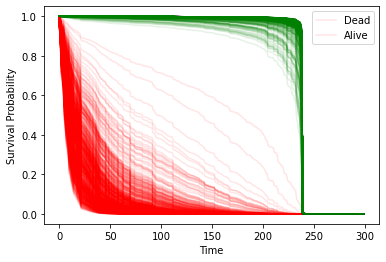

In [7]:
import matplotlib.pyplot as plt

# 获取预测的生存概率
pred_probs = np.array(testall_preds)

# 获取死亡和存活病人的索引
dead_indices = np.where(testall_events == 1)
alive_indices = np.where(testall_events == 0)

# 绘制死亡病人的生存概率曲线（红色）
for i in dead_indices[0]:
    plt.plot(pred_probs[i].cumprod(), color='red', alpha=0.1)

# 绘制存活病人的生存概率曲线（绿色）
for i in alive_indices[0]:
    plt.plot(pred_probs[i].cumprod(), color='green', alpha=0.1)

# 添加图例
plt.legend(['Dead', 'Alive'])

# 添加轴标签
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# 显示图形
plt.show()

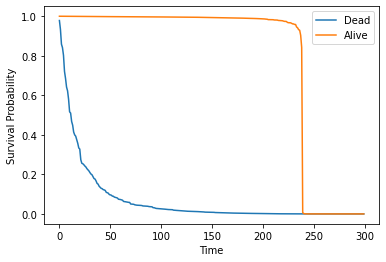

In [8]:
import matplotlib.pyplot as plt

# 获取预测的生存概率
pred_probs = np.array(testall_preds)

# 获取死亡和存活病人的索引
dead_indices = np.where(testall_events == 1)
alive_indices = np.where(testall_events == 0)

# 绘制死亡病人的生存概率曲线（红色）
plt.plot(pred_probs[dead_indices].cumprod(axis=1).mean(axis=0))
# for i in dead_indices[0]:
#     plt.plot(pred_probs[i].cumprod(), color='red', alpha=0.1)

# 绘制存活病人的生存概率曲线（绿色）
plt.plot(pred_probs[alive_indices].cumprod(axis=1).mean(axis=0))
# for i in alive_indices[0]:
#     plt.plot(pred_probs[i].cumprod(), color='green', alpha=0.1)

# 添加图例
plt.legend(['Dead', 'Alive'])

# 添加轴标签
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# 显示图形
plt.show()

In [9]:
pred_probs[dead_indices].cumprod().shape

(262500,)

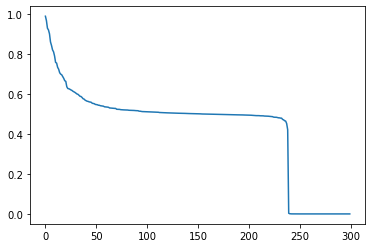

In [10]:
plt.plot(pred_probs.cumprod(axis=1).mean(axis=0))#.shape

In [11]:
pred_probs[i].prod()

3.3193862300618432e-21

In [12]:
n = 0
for i in model.state_dict():
    try:
        n += len(model.state_dict()[i])
    except:
        pass
print(n)
#     break

27400
